## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 46.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [2]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [5]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [46]:
# TODO: GAN
class GAN(pl.LightningModule):
  def __init__(self, latent_dim=100, lr=0.002):
    super().__init__()
    self.save_hyperparameters()
    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()
    # random noise
    self.validation_z = torch.randn(6, self.hparams.latent_dim)
    self.automatic_optimization = False # This line is added
    # Initialize optimizers here (but don't call .step() yet)
    self.opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
    self.opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)



  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx): # Remove optimizer_idx argument
    real_imgs, _ = batch

    # Access optimizers using self.opt_g and self.opt_d
    opt_g = self.opt_g
    opt_d = self.opt_d

    # noise data
    z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # Train generator
    opt_g.zero_grad() # Zero out generator gradients
    fake_imgs = self(z)
    y_hat = self.discriminator(fake_imgs)
    y = torch.ones(real_imgs.size(0), 1)
    y = y.type_as(real_imgs)
    g_loss = self.adversarial_loss(y_hat, y)
    self.manual_backward(g_loss) # Manually calculate gradients
    opt_g.step() # Update generator weights


    # Train discriminator
    opt_d.zero_grad() # Zero out discriminator gradients
    y_hat_real = self.discriminator(real_imgs)
    y_real = torch.ones(real_imgs.size(0), 1)
    y_real = y_real.type_as(real_imgs)
    real_loss = self.adversarial_loss(y_hat_real, y_real)

    fake_imgs = self(z)
    y_hat_fake = self.discriminator(fake_imgs.detach())
    y_fake = torch.zeros(fake_imgs.size(0), 1)
    y_fake = y_fake.type_as(real_imgs)
    fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

    d_loss = (real_loss + fake_loss) / 2
    self.manual_backward(d_loss) # Manually calculate gradients
    opt_d.step() # Update discriminator weights


    log_dict = {'g_loss': g_loss, 'd_loss': d_loss}
    return {"loss":d_loss,"progress_bar":log_dict,"log":log_dict} # You can return either g_loss or d_






  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
    return [opt_g, opt_d]

  def plot_imgs(self):
    z=self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()

    print('epoch', self.current_epoch)
    fig=plt.figure(figsize=(10, 8))
    for i in range(sample_imgs.size(0)):
      plt.subplot(2, 3, i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
    plt.show()

  def on_epoch_end(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)

    # log sampled images
    sample_imgs = self(z)
    grid = torchvision.utils.make_grid(sample_imgs)


In [47]:
dm=MNISTDataModule()
model=GAN()

# **Before training**




epoch 0


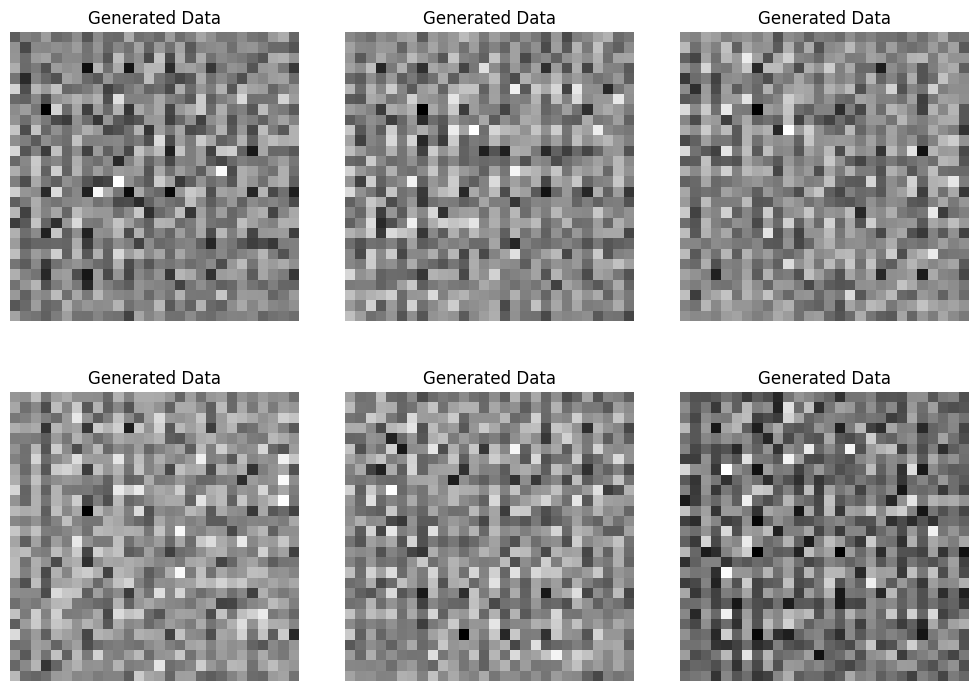

In [48]:
model.plot_imgs()

In [49]:
trainer = pl.Trainer(max_epochs=30, strategy="auto", devices=AVAIL_GPUS, enable_progress_bar=True)
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modul

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


# **After training**




epoch 30


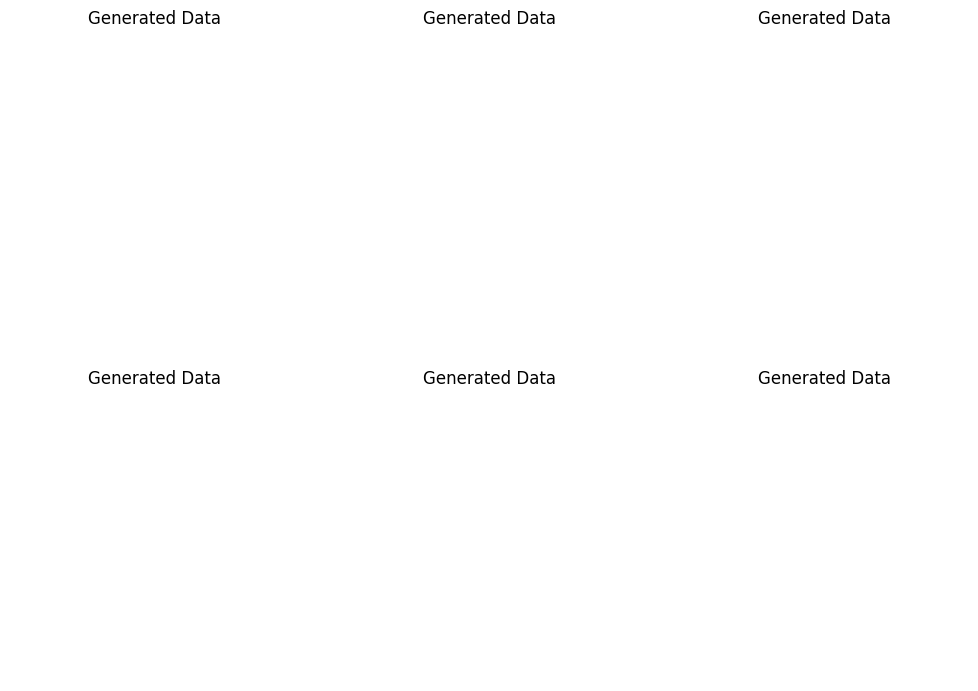

In [50]:
model.plot_imgs()